<a href="https://colab.research.google.com/github/ricardogr07/trabajo-final-aprendizaje/blob/seleccion_modelo/src/Analisis_ML_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Heart Disease Dataset

## Importar librerías

In [ ]:
# Correr esta celda unicamente si se hace desde Colab
%pip install pandas numpy

!git clone https://github.com/ricardogr07/trabajo-final-aprendizaje.git
%cd trabajo-final-aprendizaje/src
from evaluation_functions import *

### Importar librerías necesarias

- `pandas` y `numpy`: Para la manipulación de datos.
- `matplotlib.pyplot` y `seaborn`: Visualización de datos.
- `sklearn`: Selección y evaluación de modelos supervisados (regresión logística, árboles de decisión, Random Forest, SVM, k-NN).

In [1]:
# Importar librerías necesarias para el análisis y modelado de datos

# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns

# Selección y evaluación de modelos supervisados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Selección de características
from sklearn.feature_selection import SequentialFeatureSelector

# Búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Manejo del desbalanceo de clases
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Reducción de dimensionalidad y clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Pipeline para correr todo el proceso de modelado
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

## Métricas utilizadas para evaluar el rendimiento de los modelos de clasificación
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)

from evaluation_functions import *

## Carga y Preprocesamiento de Datos

En esta sección se carga el conjunto de datos de los archivos .data que contiene información sobre enfermedades cardíacas, disponible en el repositorio de UCI Machine Learning. Las columnas del conjunto de datos se especifican manualmente ya que el archivo no tiene encabezados. El dataset contiene información sobre varios factores de riesgo y el objetivo es predecir la presencia de una enfermedad cardíaca (`target`).

### Carga del dataset

In [2]:
cleveland_data_file_path = '../dataset/cleveland.data'
hungarian_data_file_path = '../dataset/hungarian.data'
switzerland_data_file_path = '../dataset/switzerland.data'
va_data_file_path = '../dataset/va.data'

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Cargar todos los datos y generar un solo dataframe
try:
    data_cleveland = pd.read_csv(cleveland_data_file_path, names = column_names)
    data_hungarian = pd.read_csv(hungarian_data_file_path, names = column_names)
    data_switzerland = pd.read_csv(switzerland_data_file_path, names = column_names)
    data_va = pd.read_csv(va_data_file_path, names = column_names)

    # Agregar location como parte de las variables, pues se usan las 4 bases de datos
    data_cleveland['location'] = 0
    data_hungarian['location'] = 1
    data_switzerland['location'] = 2
    data_va['location'] = 3

    df = pd.concat([data_cleveland, data_hungarian, data_switzerland, data_va], ignore_index=True)

except Exception as e:
    print(f"Error reading the file: {e}")


### Exploración inicial del dataset

En esta sección se realiza una inspección de la estructura del conjunto de datos para entender el tipo de variables con las que estamos trabajando. Se revisa la cantidad de entradas, los nombres de las columnas, los tipos de datos, y si hay valores faltantes. Es importante notar que algunas columnas tienen el tipo `object`, lo que indica que pueden contener valores categóricos o valores que no han sido correctamente identificados como numéricos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  920 non-null    object 
 4   chol      920 non-null    object 
 5   fbs       920 non-null    object 
 6   restecg   920 non-null    object 
 7   thalach   920 non-null    object 
 8   exang     920 non-null    object 
 9   oldpeak   920 non-null    object 
 10  slope     920 non-null    object 
 11  ca        920 non-null    object 
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
 14  location  920 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 107.9+ KB


In [4]:
for columna in df.columns:
    valores_unicos = df[columna].unique()
    print(f"Valores únicos en la columna '{columna}':")
    print(valores_unicos)
    print('\n')

Valores únicos en la columna 'age':
[63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76. 28. 30. 31. 32. 33. 36. 72. 73. 75.]


Valores únicos en la columna 'sex':
[1. 0.]


Valores únicos en la columna 'cp':
[1. 4. 3. 2.]


Valores únicos en la columna 'trestbps':
[145.0 160.0 120.0 130.0 140.0 172.0 150.0 110.0 132.0 117.0 135.0 112.0
 105.0 124.0 125.0 142.0 128.0 170.0 155.0 104.0 180.0 138.0 108.0 134.0
 122.0 115.0 118.0 100.0 200.0 94.0 165.0 102.0 152.0 101.0 126.0 174.0
 148.0 178.0 158.0 192.0 129.0 144.0 123.0 136.0 146.0 106.0 156.0 154.0
 114.0 164.0 '130' '120' '140' '170' '100' '105' '110' '125' '150' '98'
 '112' '145' '190' '160' '115' '142' '180' '132' '135' '?' '108' '124'
 '113' '122' '92' '118' '106' '200' '138' '136' '128' '155' '95' '165'
 '80' '185' '126' '152' '116' '0' '144' '154' '104' '134' '178' '146'
 '158' '102' '96' '172' '156' '114' '127']




Al examinar los valores únicos presentes en las columnas se descubre que existen múltiples columnas que contienen el valor '?' en lugar de un valor numérico. Este es un indicador de datos faltantes o incorrectos que deberán ser manejados antes de continuar con el análisis.
Adicionalmente, hay columnas que tienen como valor un `string` en lugar de un `int` o `float`, por lo que va a ser necesario estandarizar estos valores.

### Preprocesar Datos

En esta sección, se manejan los valores faltantes representados por el símbolo `'?'`:

* Primero, se reemplazan estos valores por `NaN` (not a number) para que pandas pueda identificarlos como datos faltantes.

* Luego, se convierten las columnas afectadas en tipo `float`, ya que originalmente estaban mal interpretadas como `object`.

* Posteriormente, se eliminan las filas que contienen valores nulos.

* Finalmente, se revisan estadísticas descriptivas del dataset limpio.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  920 non-null    object 
 4   chol      920 non-null    object 
 5   fbs       920 non-null    object 
 6   restecg   920 non-null    object 
 7   thalach   920 non-null    object 
 8   exang     920 non-null    object 
 9   oldpeak   920 non-null    object 
 10  slope     920 non-null    object 
 11  ca        920 non-null    object 
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
 14  location  920 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 107.9+ KB


In [6]:
# Reemplazar los valores '?' por NaN
df.replace('?', np.nan, inplace=True)

# Convertir las columnas que deben ser numéricas a tipo float (algunas están como objetos)
df = df.apply(pd.to_numeric, errors='coerce')

# Verificar los datos nulos después del reemplazo
display(df.isnull().sum())

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
location      0
dtype: int64

Existe un gran número de datos faltantes para las columnas `slope`, `ca` y `thal`. Sería necesario eliminar estas características para tener una mayor cantidad de datos, pero podría hacer el modelado menos exacto. También es posible eliminar los datos faltantes para tener la mayor cantidad de características para el modelo.

Vamos por el momento a eliminar los datos incompletos para evaluar un modelo con todas las características, posteriormente se tomará el modelo sin estas características y compararemos cuál nos da mejores métricas de desempeño.

Dependiendo de esto, volveremos a este paso para determinar nuevamente que es lo que tenemos que hacer para maximizar la información de nuestro modelo.

In [7]:
# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Estadísticas descriptivas
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,location
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,0.67893,3.163880,131.715719,246.785953,0.143813,0.989967,149.327759,0.331104,1.058528,1.605351,0.672241,4.745819,0.946488,0.013378
std,9.030264,0.46767,0.964069,17.747751,52.532582,0.351488,0.994903,23.121062,0.471399,1.162769,0.616962,0.937438,1.940977,1.230409,0.182695
min,29.000000,0.00000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.00000,3.000000,120.000000,211.000000,0.000000,0.000000,132.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,56.000000,1.00000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.00000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,0.000000
max,77.000000,1.00000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,3.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       299 non-null    float64
 1   sex       299 non-null    float64
 2   cp        299 non-null    float64
 3   trestbps  299 non-null    float64
 4   chol      299 non-null    float64
 5   fbs       299 non-null    float64
 6   restecg   299 non-null    float64
 7   thalach   299 non-null    float64
 8   exang     299 non-null    float64
 9   oldpeak   299 non-null    float64
 10  slope     299 non-null    float64
 11  ca        299 non-null    float64
 12  thal      299 non-null    float64
 13  target    299 non-null    int64  
 14  location  299 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 37.4 KB


Tras eliminar todos los datos faltantes, tenemos un total de 299 valores para nuestras 15 características y nuestro target.

Vamos a revisar ahora nuestra variable generada `location` y nuestra variable objetivo.

In [9]:
display(df['location'].value_counts())

display(df['target'].value_counts())

location
0    297
1      1
3      1
Name: count, dtype: int64

target
0    160
1     56
2     35
3     35
4     13
Name: count, dtype: int64

Para `location` tenemos que se encuentra muy desbalanceada, por lo que probablemente no aporte ninguna información relevante en este modelo actual, por lo que vamos a decidir eliminarla del dataset.

Para `target` la clasificación es algo desbalanceada, vemos que los valores del 1 al 4 incluyen múltiples niveles de la enfermedad, pero para nuestros fines, únicamente nos interesa saber si el paciente tiene o no la enfermedad dadas las características mencionadas anteriormente.

Por lo anterior, se ha decidido usar una variable binaria `target_cat` que sea 0 si no existe la enfermedad y 1 si esta presente.

In [10]:
# Eliminar la columna location, pues no aporta información relevante
df.drop('location', axis=1, inplace=True)

# Crear una nueva columna 'target_cat' que sea binaria (1 si target > 0, 0 en caso contrario)
df['target_cat'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

Ahora podemos observar la distribución de la variable objetivo, y definir la clasificación binaria que haremos siendo:

0 - No existe enfermedad cardiovascular

1 - Existe enfermedad cardiovascular

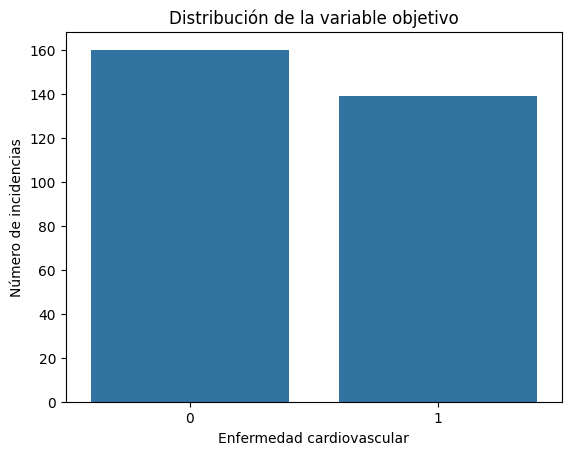

In [11]:
# Visualización de la distribución de la variable objetivo
sns.countplot(x='target_cat', data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel('Enfermedad cardiovascular')
plt.ylabel('Número de incidencias')
plt.show()

Vemos que las clases están un poco desbalanceadas, por lo que probablemente tengas que hacer algún tipo de rebalanceo como preprocesamiento antes de hacer el ajuste del modelo.

## Análisis exploratorio de datos


Con los datos ahora limpios y adecuadamente preparados, la siguiente sección se enfocará en el análisis exploratorio de datos (EDA). Este paso es fundamental para comprender en profundidad las características y estructuras subyacentes del conjunto de datos.

A través del EDA, examinaremos distribuciones, relaciones y patrones entre las variables, lo que nos permitirá identificar tendencias significativas, detectar anomalías o valores atípicos y formular hipótesis informadas.

### Variables del dataset

In [12]:
display(df.drop('target', axis=1).head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target_cat
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


La tabla presentada contiene datos clínicos de pacientes relacionados con parámetros cardiovasculares, utilizados para el análisis de enfermedades del corazón. Cada fila representa a un paciente con diversas características:

Demográficas y generales:
* age: Edad del paciente en años.
* sex: Sexo del paciente (1.0 para masculino y 0.0 para femenino).

Parámetros clínicos:
* cp: Tipo de dolor de pecho experimentado.
* trestbps: Presión arterial en reposo en mm Hg.
* chol: Colesterol sérico en mg/dl.
* fbs: Azúcar en ayunas (1.0 si es mayor a 120 mg/dl, 0.0 en caso contrario).
* restecg: Resultados del electrocardiograma en reposo.
* thalach: Frecuencia cardíaca máxima alcanzada.
* exang: Angina inducida por ejercicio (1.0 sí, 0.0 no).
* oldpeak: Depresión del segmento ST inducida por el ejercicio en relación con el reposo.
* slope: Pendiente del segmento ST en el ejercicio máximo.
* ca: Número de vasos principales coloreados por fluoroscopia.
* thal: Resultado de la prueba de talio (3.0 normal, 6.0 defecto fijo, 7.0 defecto reversible).

Variables objetivo:
* target_cat: Categoría simplificada de la variable objetivo (0 para ausencia y 1 para presencia de enfermedad).

### Correlación entre variables

Realizamos el siguiente análisis para visualizar las correlaciones entre las variables independientes del conjunto de datos. Al eliminar la columnas 'target', nos enfocamos exclusivamente en las características o predictores, lo cual es esencial para entender cómo se relacionan entre sí sin la influencia de la variable objetivo.

Este análisis es útil por tres razones principales: primero, para identificar multicolinealidad, ya que variables altamente correlacionadas pueden afectar negativamente el rendimiento de algunos modelos; segundo, para entender las relaciones internas entre las variables, lo que puede ofrecer información sobre el comportamiento del sistema; y tercero, para mejorar el modelo predictivo al seleccionar características más relevantes y evitar incluir variables redundantes que no aportan nueva información.

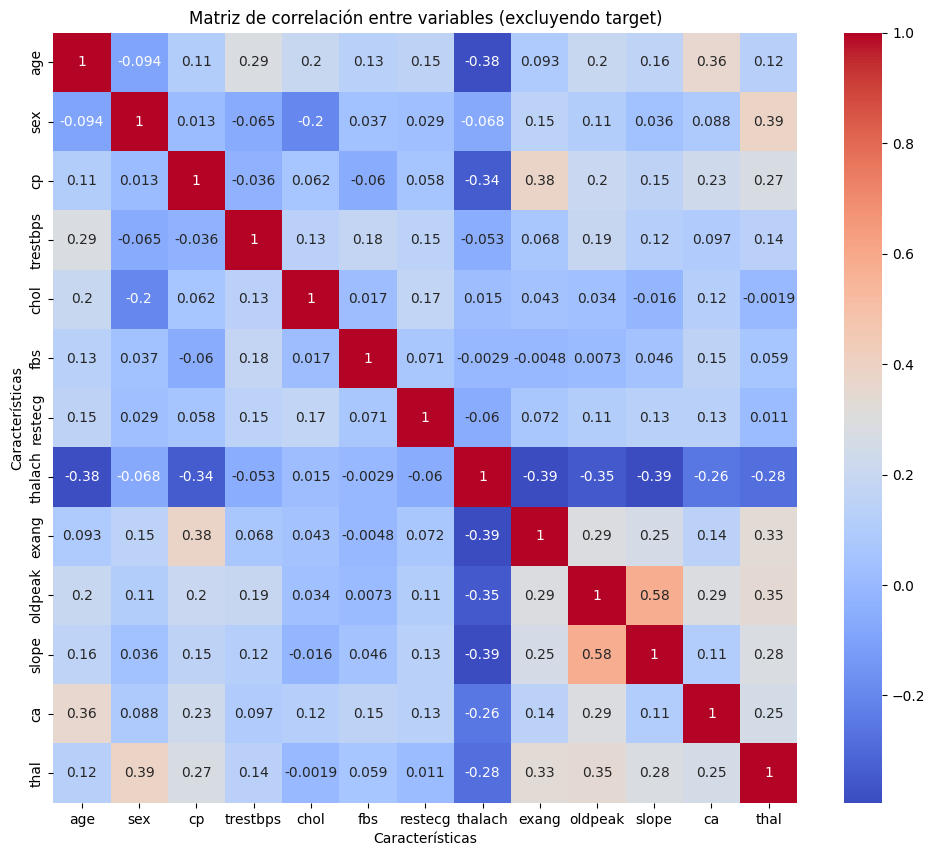

In [13]:
# Calcular la matriz de correlación excluyendo 'target' y 'target_cat'
correlation_matrix = df.drop(['target', 'target_cat'], axis=1).corr()

# Crear el heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Matriz de correlación entre variables (excluyendo target)')
plt.xlabel('Características')
plt.ylabel('Características')
plt.show()

En la matriz de correlación observamos varias relaciones significativas entre las variables, destacando aquellas con alta correlación entre sí.

Se identifican correlaciones moderadas que sugieren potencial multicolinealidad, como la relación entre `cp` (tipo de dolor en el pecho) y `exang` (angina inducida por ejercicio) con 0.38, y entre `slope` y `oldpeak` con 0.58. Estas correlaciones podrían indicar información redundante.

Sin embargo, un umbral comúnmente utilizado para identificar multicolinealidad problemática es una correlación absoluta mayor a 0.7 o 0.8. En el caso específico de las correlaciones identificadas en la matriz, ninguna de estas relaciones supera el umbral de 0.7, por lo que, según este criterio general, no es necesario eliminarlas por multicolinealidad.

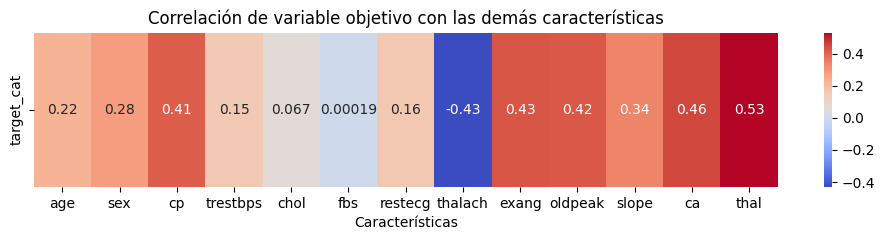

In [14]:
# Calcular la correlación de 'target_cat' con las demás características
correlation_with_target = df.corr()['target_cat'].drop(['target_cat', 'target'])

# Convertir a DataFrame para la visualización en heatmap
correlation_df = correlation_with_target.to_frame().T

# Crear heatmap de las correlaciones
plt.figure(figsize=(12, 2))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlación de variable objetivo con las demás características')
plt.xlabel('Características')
plt.show()

El heatmap muestra la correlación de la variable objetivo `target_cat` con las demás características del conjunto de datos, proporcionando una visión clara de cuáles variables tienen mayor influencia en la predicción del resultado. Se destacan `thal` y `ca` como las variables con la correlación más alta (0.53 y 0.46, respectivamente), indicando una fuerte asociación con el target y sugiriendo que son características clave para el modelo predictivo.

Por otro lado, `thalach` muestra una correlación negativa significativa (-0.43), lo que indica que valores altos de esta variable están asociados con un menor valor de `target_cat`. Variables como `fbs` y `chol` presentan correlaciones muy bajas (0.00019 y 0.067), sugiriendo que su influencia sobre la variable objetivo es mínima y podrían ser consideradas menos relevantes en el análisis predictivo.

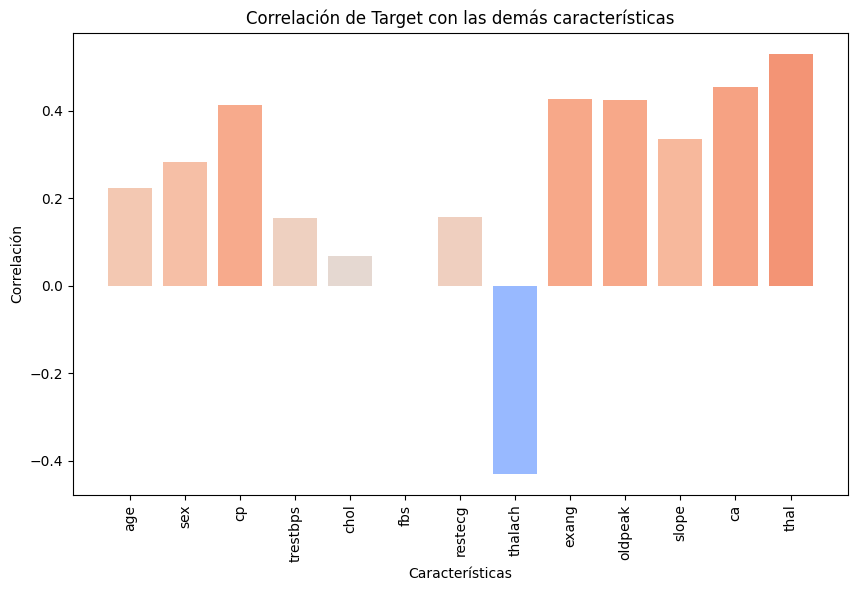

In [15]:
# Calcular la correlación de 'target' con las demás columnas
correlation_with_target = df.corr()['target_cat'].drop(['target_cat', 'target'])

# Crear una paleta de colores basada en los valores de correlación
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
colors = plt.cm.coolwarm(norm(correlation_with_target.values))

# Convertir la paleta de colores a una lista para que sea compatible
colors_list = colors.tolist()

# Visualizar la correlación de 'target' con las demás variables usando Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(
    x=correlation_with_target.index,
    height=correlation_with_target.values,
    color=colors_list
)
plt.title('Correlación de Target con las demás características')
plt.xticks(rotation=90)
plt.ylabel('Correlación')
plt.xlabel('Características')
plt.show()

En el gráfico anterior, se observa la correlación de la variable objetivo (target) con las demás características del conjunto de datos. Las variables con mayor correlación positiva con el target son cp (tipo de dolor en el pecho), thal, ca, slope y exang, todas con valores cercanos a 0.4 o superiores. Estas relaciones indican que estas variables están fuertemente asociadas con la predicción de la variable objetivo y son candidatas clave para ser incluidas en el modelo predictivo.

Por otro lado, thalach (frecuencia cardíaca máxima) muestra una correlación negativa significativa, alrededor de -0.4, lo que sugiere que a medida que esta variable aumenta, la probabilidad del resultado objetivo disminuye, lo cual puede ser una característica relevante en el análisis de riesgo cardiovascular.

Las demás variables, como chol, fbs y restecg, presentan correlaciones cercanas a cero, indicando que tienen un impacto mínimo en el target y podrían ser consideradas para una revisión adicional o posible eliminación del modelo si su inclusión no agrega valor predictivo.

#### Creación de dummy variables basadas en variables categóricas

Las variables categóricas representan datos en categorías sin un orden numérico inherente, y los algoritmos de aprendizaje automático requieren datos numéricos para procesar información.

Convertir directamente estas categorías en números puede llevar a interpretaciones erróneas, ya que el modelo podría asumir relaciones de magnitud que no existen.

Por ello, es esencial crear variables dummy que transformen cada categoría en columnas binarias (0 o 1), indicando la presencia o ausencia de cada categoría.

Al utilizar `drop_first=True` en `pd.get_dummies`, eliminamos una categoría redundante por variable, evitando la multicolinealidad y mejorando la estabilidad y eficiencia del modelo.

In [16]:
# Definir las variables categóricas
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

# Crear variables dummy solo para las columnas categóricas
df_clean = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

## Selección de modelo usando técnicas de aprendizaje supervisado


Primero vamos a separar las características (X) de la variable objetivo (y). Luego, se divide el conjunto de datos en entrenamiento y prueba usando `train_test_split`, asegurando que el 20% de los datos se reserve para prueba y que la proporción de las clases en y se mantenga constante gracias al parámetro `stratify=y`. Esta división es crucial para evaluar el rendimiento del modelo en datos no vistos, evitando sobreajuste y asegurando una evaluación justa y reproducible del modelo.

In [17]:
# Separar características (X) y la nueva variable objetivo (y)
X = df_clean.drop(columns=['target_cat', 'target'])
y = df_clean['target_cat']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Selección de características


La selección de características mejora el rendimiento del modelo al eliminar variables irrelevantes, reduciendo el ruido y el riesgo de sobreajuste. Esto facilita que el modelo generalice mejor, reduce tiempos de entrenamiento y simplifica la interpretación, destacando solo las variables más influyentes en las predicciones.

En esta sección vamos a usar dos tipos de selección de característica: selección hacia adelante y hacia atrás, para hacer una comparación con la métrica F1_score pues nos importan los falsos negativos dentro de este dataset.

Vamos a definir los componentes base para la creación de un modelo de clasificación binario:

`models` especifica el uso de la Regresión Logística con ajuste de pesos para clases desbalanceadas
`samplers` indica que no se aplicará ninguna técnica de muestreo por ahora
`scalers` establece el uso de StandardScaler para estandarizar los datos

Se define una función de puntuación personalizada `f1_scorer` enfocada en la métrica F1, crucial para problemas de clasificación con clases desbalanceadas.

Los métodos de selección de características (feature_selection) incluyen opciones de selección hacia adelante y hacia atrás utilizando `SequentialFeatureSelector`, lo que permite refinar las características utilizadas por el modelo.

Con estos componentes, se crean múltiples pipelines, evaluándolos con los datos de entrenamiento y prueba, para finalmente mostrar las métricas obtenidas, permitiendo una comparación clara del rendimiento de cada pipeline en términos de precisión y ajuste.

In [18]:
# Modelos
models = {
     'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

# Samplers
samplers = {
    'None': None
}

# Escaladores
scalers = {
    'StandardScaler': StandardScaler()
}

# Definir f1 como función de scoring
f1_scorer = make_scorer(f1_score, zero_division=0)

# Definir métodos de selección de características
feature_selection = {
    'None': lambda model: None,
    'Forward Selection': lambda model: SequentialFeatureSelector(
        estimator=model,
        direction='forward',
        scoring=f1_scorer,
        n_jobs=-1
    ),
    'Backward Selection': lambda model: SequentialFeatureSelector(
        estimator=model,
        direction='backward',
        scoring=f1_scorer,
        n_jobs=-1
    )
}

# Generar una pipeline para cada combinación de modelo, escalador, sampler y modelo de selección
pipelines_feature_selection = create_pipelines(models, samplers, feature_selection, scalers)

# Evaluar cada pipeline y determinar sus métricas
results = evaluate_pipelines(X, y, pipelines_feature_selection)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.824113,0.806212,0.828458,0.813962,0.900433
1,Logistic Regression - StandardScaler - Forward...,0.773670,0.736960,0.819763,0.772605,0.861380
2,Logistic Regression - StandardScaler - Backwar...,0.845035,0.845493,0.819763,0.828061,0.900355



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.80,0.833333,0.714286,0.769231,0.907366
1,Logistic Regression - StandardScaler - Forward...,0.75,0.782609,0.642857,0.705882,0.866071
2,Logistic Regression - StandardScaler - Backwar...,0.75,0.782609,0.642857,0.705882,0.895089


Los resultados anteriores muestran las métricas de rendimiento tanto en validación cruzada como en el conjunto de prueba para diferentes configuraciones de la Regresión Logística, ya que queremos determinar el mejor conjunto de características para trabajar con el modelo.

En la validación cruzada, el pipeline con la Regresión Logística utilizando StandardScaler sin selección de características obtuvo el mejor rendimiento en términos de F1-score (0.817633) y AUC (0.901120), lo cual indica un buen balance entre precisión y recall y una capacidad robusta de discriminación entre clases.

En el conjunto de prueba, el modelo con StandardScaler sin selección de características logró el mejor F1-score de 0.769231. Además, el modelo con StandardScaler sin selección de características también mostró un AUC superior (0.907366), sugiriendo un mejor desempeño en la clasificación de clases positivas frente a negativas.

Por lo tanto, basado en el F1-score y un desempeño superior en AUC, el mejor modelo es el que utiliza Regresión Logística con StandardScaler sin selección de características.

### Verificar modelo eliminando las características con el menor número de datos

Ahora vamos a verificar el modelo si es que quitaramos las variables categóricas que tenían el mayor número de datos faltantes para comprobar como cambian las métricas con los mismos pipelines que anteriormente habíamos generado.

In [19]:
# Pasos de limpieza añadiendo eliminar las características con el mayor número de datos inválidos

df_2 = pd.concat([data_cleveland, data_hungarian, data_switzerland, data_va], ignore_index=True)

# Reemplazar los valores '?' por NaN
df_2.replace('?', np.nan, inplace=True)

# Convertir las columnas que deben ser numéricas a tipo float (algunas están como objetos)
df_2 = df_2.apply(pd.to_numeric, errors='coerce')

# Eliminar características con mayor número de datos inválidos
df_drop_features = df_2.drop(columns=['slope', 'ca', 'thal'])

# Eliminar filas con valores nulos
df_drop_features.dropna(inplace=True)

# Crear una nueva columna 'target_cat' que sea binaria (1 si target > 0, 0 en caso contrario)
df_drop_features['target_cat'] = df_drop_features['target'].apply(lambda x: 1 if x > 0 else 0)

In [20]:
df_drop_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 740 entries, 0 to 919
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         740 non-null    float64
 1   sex         740 non-null    float64
 2   cp          740 non-null    float64
 3   trestbps    740 non-null    float64
 4   chol        740 non-null    float64
 5   fbs         740 non-null    float64
 6   restecg     740 non-null    float64
 7   thalach     740 non-null    float64
 8   exang       740 non-null    float64
 9   oldpeak     740 non-null    float64
 10  target      740 non-null    int64  
 11  location    740 non-null    int64  
 12  target_cat  740 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 80.9 KB


In [21]:
# Definir las variables categóricas que no se han eliminado
categorical_columns_dropped = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'location']

# Crear variables dummy solo para las columnas categóricas
df_clean_dropped = pd.get_dummies(df_drop_features, columns=categorical_columns_dropped, drop_first=True)

X_drop_features = df_clean_dropped.drop(['target_cat', 'target'], axis=1)
y_drop_features = df_clean_dropped['target_cat']

In [22]:
# Evaluar cada pipeline y determinar sus métricas
results = evaluate_pipelines(X_drop_features, y_drop_features, pipelines_feature_selection)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.797265,0.819335,0.784030,0.799142,0.887397
1,Logistic Regression - StandardScaler - Forward...,0.756758,0.757447,0.781121,0.768867,0.842317
2,Logistic Regression - StandardScaler - Backwar...,0.785501,0.797892,0.787361,0.790754,0.882197



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.844595,0.864865,0.831169,0.847682,0.902140
1,Logistic Regression - StandardScaler - Forward...,0.837838,0.863014,0.818182,0.840000,0.912018
2,Logistic Regression - StandardScaler - Backwar...,0.831081,0.833333,0.844156,0.838710,0.908542


Falta comparar las métricas de ambos datasets y determinar con cuál nos vamos a quedar:

* ¿Con cuál dataset deberiamos quedarnos el que tiene más caracteristicas pero una muestra menor o el que tiene una muestra más grande pero menos características?

* ¿Con qué modelo deberíamos quedarnos sin feature selection, backward o forward?

Usar el conjunto de datos con 740 pacientes y menos características?

Esta combinación aprovecha la estabilidad de una muestra mayor y mantiene la potencia predictiva de un modelo que utiliza todas las características disponibles, ofreciendo un equilibrio entre precisión y capacidad de generalización.

### Validación de balanceo de clases


Aunque en este caso específico las clases están relativamente balanceadas, hacer el resampling es crucial en escenarios de desbalanceo significativo para asegurar que los modelos no solo alcancen altos valores de exactitud, sino que también funcionen de manera efectiva en el contexto específico de la predicción de interés, manejando correctamente ambas clases y reduciendo el riesgo de errores críticos en la clasificación.

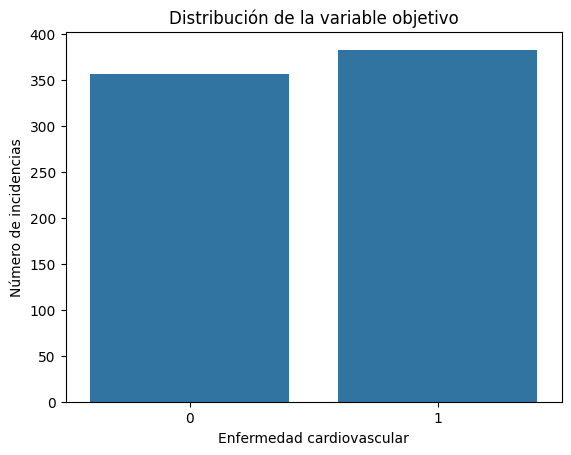

In [23]:
# Visualización de la distribución de la variable objetivo
sns.countplot(x='target_cat', data=df_clean_dropped)
plt.title('Distribución de la variable objetivo')
plt.xlabel('Enfermedad cardiovascular')
plt.ylabel('Número de incidencias')
plt.show()

En este caso específico, tal vez no vale la pena aplicar resampling, ya que las clases están razonablemente equilibradas y el rendimiento del modelo es bueno. La implementación de resampling podría ser innecesaria y potencialmente modificar el equilibrio actual del modelo. Se recomienda mantener el enfoque actual y monitorear las métricas de rendimiento, asegurando que el modelo continúe funcionando adecuadamente en ambas clases. Se realiza esto como ejercicio para comprobar que no es necesario el resampling.

In [24]:
# Escaladores
scalers = {
    'StandardScaler': StandardScaler()
}

# Samplers
samplers = {
    'None': None,  # Sin remuestreo
    'SMOTE': SMOTE(random_state=42),
    'Random Oversampling': RandomOverSampler(random_state=42),
    'Random Undersampling': RandomUnderSampler(random_state=42),
    'NearMiss': NearMiss(version=1)
}

# Modelos
models = {
     'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

# Crear pipelines a evaluar
pipelines_resampling = create_pipelines(models, samplers, scalers=scalers)

# Evaluar los pipelines
results = evaluate_pipelines(X_drop_features, y_drop_features, pipelines_resampling)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.797265,0.819335,0.784030,0.799142,0.887397
1,Logistic Regression - SMOTE - StandardScaler,0.795570,0.816263,0.784030,0.797368,0.886253
2,Logistic Regression - Random Oversampling - St...,0.798932,0.818949,0.787308,0.801001,0.887004
3,Logistic Regression - Random Undersampling - S...,0.798946,0.824093,0.780751,0.799552,0.886311
4,Logistic Regression - NearMiss - StandardScaler,0.793890,0.804665,0.797091,0.799137,0.886315



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.844595,0.864865,0.831169,0.847682,0.902140
1,Logistic Regression - SMOTE - StandardScaler,0.837838,0.863014,0.818182,0.840000,0.905067
2,Logistic Regression - Random Oversampling - St...,0.851351,0.866667,0.844156,0.855263,0.899762
3,Logistic Regression - Random Undersampling - S...,0.837838,0.853333,0.831169,0.842105,0.905067
4,Logistic Regression - NearMiss - StandardScaler,0.844595,0.855263,0.844156,0.849673,0.904884


Modelo con más variables y menos datos

In [25]:
results = evaluate_pipelines(X, y, pipelines_resampling)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.824113,0.806212,0.828458,0.813962,0.900433
1,Logistic Regression - SMOTE - StandardScaler,0.828369,0.810550,0.837549,0.820177,0.900360
2,Logistic Regression - Random Oversampling - St...,0.836702,0.826070,0.828458,0.824999,0.904977
3,Logistic Regression - Random Undersampling - S...,0.824113,0.827722,0.801976,0.807449,0.905312
4,Logistic Regression - NearMiss - StandardScaler,0.836613,0.819790,0.837154,0.826630,0.905292



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - StandardScaler,0.800000,0.833333,0.714286,0.769231,0.907366
1,Logistic Regression - SMOTE - StandardScaler,0.800000,0.833333,0.714286,0.769231,0.908482
2,Logistic Regression - Random Oversampling - St...,0.783333,0.800000,0.714286,0.754717,0.891741
3,Logistic Regression - Random Undersampling - S...,0.833333,0.875000,0.750000,0.807692,0.921875
4,Logistic Regression - NearMiss - StandardScaler,0.750000,0.760000,0.678571,0.716981,0.879464


¿Queremos seleccionar Random Oversampling o no utilizar ningun resampling en este caso?

### Selección de modelo supervisado


In [26]:
# Escaladores
scalers = {
    'None': None
}

# Definir samplers
samplers = {
    'Random Oversampling': RandomOverSampler(random_state=42),
}

# Modelos que no necesitan escalador necesariamente
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

pipelines_models = create_pipelines(models, samplers, scalers=scalers)

results = evaluate_pipelines(X_drop_features, y_drop_features, pipelines_models)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree - Random Oversampling,0.716166,0.720845,0.735061,0.727567,0.715443
1,Random Forest - Random Oversampling,0.798932,0.809616,0.800423,0.803632,0.871458



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree - Random Oversampling,0.729730,0.746667,0.727273,0.736842,0.729834
1,Random Forest - Random Oversampling,0.804054,0.807692,0.818182,0.812903,0.886226


In [27]:
# Escaladores necesarios para LR, SVC y KNN
scalers = {
    'StandardScaler': StandardScaler()
}

# Definir resampling
samplers = {
    'Random Oversampling': RandomOverSampler(random_state=42),
}

# Modelos
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

pipelines_models_scaled = create_pipelines(models, samplers, scalers=scalers)

results = evaluate_pipelines(X_drop_features, y_drop_features, pipelines_models_scaled)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - Random Oversampling - St...,0.798932,0.818949,0.787308,0.801001,0.887004
1,Decision Tree - Random Oversampling - Standard...,0.719598,0.735101,0.715389,0.724116,0.719582
2,Random Forest - Random Oversampling - Standard...,0.787139,0.803113,0.784135,0.791724,0.867577
3,SVC - Random Oversampling - StandardScaler,0.814101,0.831481,0.810312,0.818550,0.880463
4,K-Nearest Neighbors - Random Oversampling - St...,0.792152,0.803750,0.793919,0.797249,0.851133



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - Random Oversampling - St...,0.851351,0.866667,0.844156,0.855263,0.899762
1,Decision Tree - Random Oversampling - Standard...,0.736486,0.771429,0.701299,0.734694,0.737973
2,Random Forest - Random Oversampling - Standard...,0.783784,0.792208,0.792208,0.792208,0.880830
3,SVC - Random Oversampling - StandardScaler,0.817568,0.820513,0.831169,0.825806,0.895372
4,K-Nearest Neighbors - Random Oversampling - St...,0.790541,0.810811,0.779221,0.794702,0.854308


Modelo más variables, menos datos

In [29]:
# Escaladores
scalers = {
    'StandardScaler': StandardScaler()
}

# Definir samplers
samplers = {
    'Random Undersampling': RandomUnderSampler(random_state=42),
}

# Modelos
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

pipelines_list = create_pipelines(models, samplers, scalers=scalers)

# Evaluar los pipelines
results = evaluate_pipelines(X, y, pipelines_list)

display_metrics(results)

Cross-Validation Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - Random Undersampling - S...,0.824113,0.827722,0.801976,0.807449,0.905312
1,Decision Tree - Random Undersampling - Standar...,0.740603,0.702446,0.783794,0.736899,0.744051
2,Random Forest - Random Undersampling - Standar...,0.799202,0.783957,0.774704,0.775233,0.893638
3,SVC - Random Undersampling - StandardScaler,0.815780,0.800101,0.820553,0.802700,0.914003
4,K-Nearest Neighbors - Random Undersampling - S...,0.782270,0.773491,0.784190,0.768544,0.856050



Test Set Metrics:


,Method,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression - Random Undersampling - S...,0.833333,0.875000,0.750000,0.807692,0.921875
1,Decision Tree - Random Undersampling - Standar...,0.716667,0.739130,0.607143,0.666667,0.709821
2,Random Forest - Random Undersampling - Standar...,0.816667,0.814815,0.785714,0.800000,0.881138
3,SVC - Random Undersampling - StandardScaler,0.833333,0.846154,0.785714,0.814815,0.924107
4,K-Nearest Neighbors - Random Undersampling - S...,0.800000,0.863636,0.678571,0.760000,0.906808


### Ajuste de hiperparámetros del modelo


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_drop_features, y_drop_features, test_size=0.2, random_state=42, stratify=y_drop_features)

In [35]:
# Definir el pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Ajustar los hiperparámetros
param_grid = [
    {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2', None],
        'classifier__solver': ['lbfgs', 'saga'],
    },
    {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
    },
    {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.0, 0.5, 1.0]
    }
]

# Configurar la estrategia de validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Ajustar el GridSearchCV en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")


Fitting 5 folds for each of 55 candidates, totalling 275 fits
Mejores hiperparámetros: {'classifier__C': 0.1, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}


### Evaluación del modelo seleccionado


In [36]:
# Usar el mejor modelo obtenido de GridSearchCV
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

# Convertir el diccionario en un DataFrame
metrics = {
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-score": [f1],
    "AUC-ROC": [auc]
}

metrics_df = pd.DataFrame(metrics, index=["Best Model"])
display(metrics_df)

,Accuracy,Precision,Recall,F1-score,AUC-ROC
Best Model,0.858108,0.868421,0.857143,0.862745,0.909091


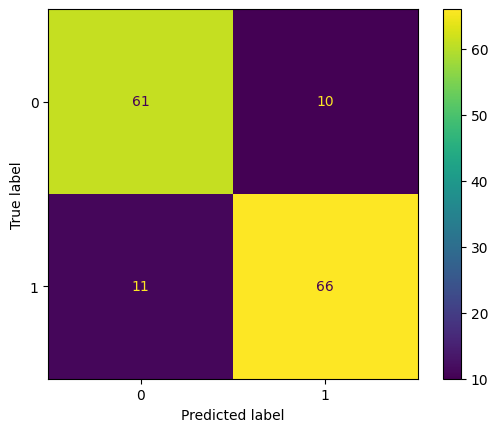

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

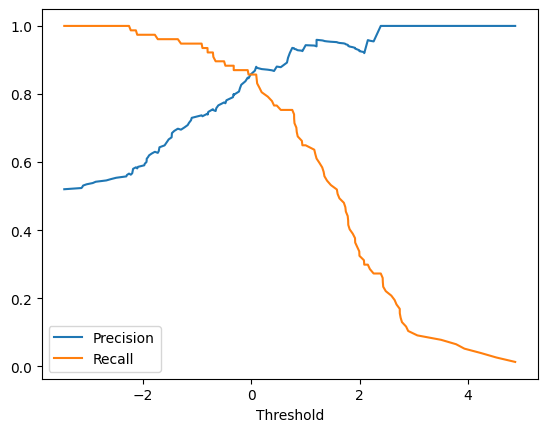

In [38]:
y_scores = best_model.decision_function(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Modelo más parámetros con menos datos

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
# Definir el pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', SVC(probability=True))
])

# Definir los hiperparámetros que vamos a ajustar
param_grid = [
    {
        'classifier__kernel': ['linear'],
        'classifier__C': [0.1, 1, 10, 100],
    },
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier__kernel': ['poly'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__degree': [2, 3, 4],
        'classifier__gamma': ['scale', 'auto']
    }
]

# Configurar la validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Ejecutar el ajuste de hiperparámetros
grid_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


In [42]:
# Usar el mejor modelo obtenido de GridSearchCV
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

# Convertir el diccionario en un DataFrame
metrics = {
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-score": [f1],
    "AUC-ROC": [auc]
}

metrics_df = pd.DataFrame(metrics, index=["Mejor Modelo Mas Categorías"])
display(metrics_df)

,Accuracy,Precision,Recall,F1-score,AUC-ROC
Mejor Modelo Mas Categorías,0.833333,0.846154,0.785714,0.814815,0.924107


## Análisis de clúster con aprendizaje no supervisado


### PCA


In [43]:
# Escalar los datos para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_drop_features)

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar la cantidad de varianza explicada por las dos primeras componentes principales
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por las primeras dos componentes: {explained_variance}")

Varianza explicada por las primeras dos componentes: [0.20821463 0.11391912]


### Clustering


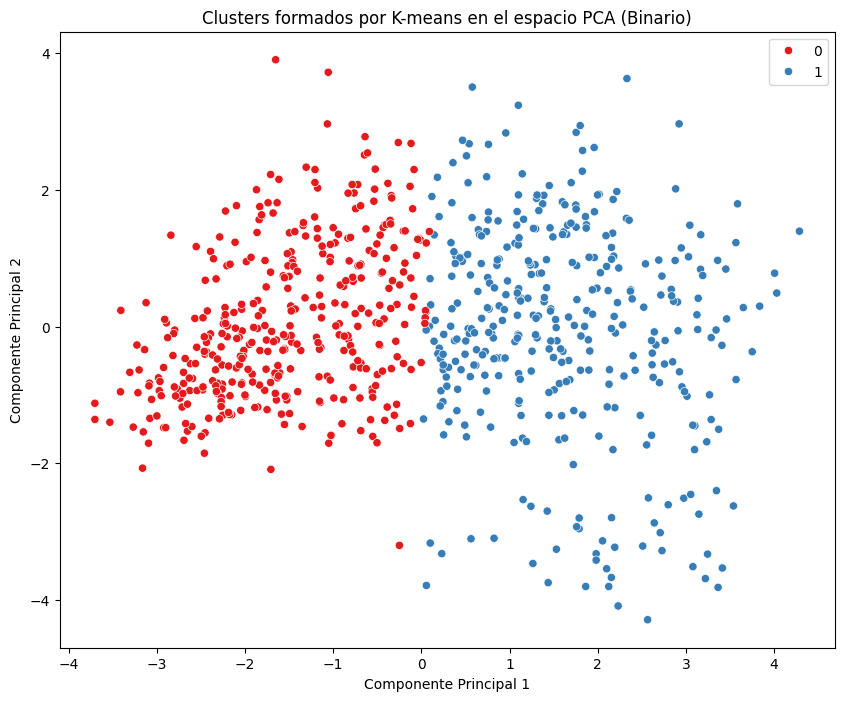

In [44]:
# Aplicar K-means para clustering (en este caso binario, utilizamos 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)

# Obtener los labels del clustering
labels_kmeans = kmeans.labels_

# Visualizar los clusters de K-means en el espacio PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='Set1', legend='full')
plt.title('Clusters formados por K-means en el espacio PCA (Binario)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

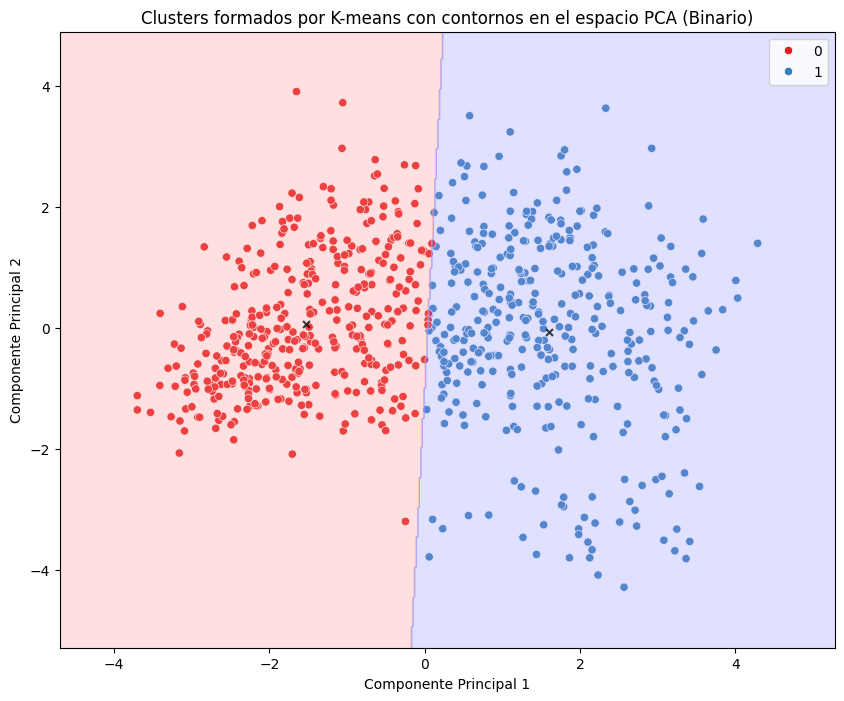

In [45]:
# Obtener los labels del clustering
labels_kmeans = kmeans.labels_

# Obtener los centros de los clusters
centroids = kmeans.cluster_centers_

# Visualizar los clusters con los contornos
plt.figure(figsize=(10, 8))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='Set1', legend='full')

# Dibujar contornos (líneas de decisión) para cada cluster
# Crear una malla de puntos para evaluar el modelo en toda el área
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predecir los clusters para cada punto en la malla
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Crear una paleta de colores personalizada que coincida con los colores de los puntos
custom_cmap = ListedColormap(['#FF9999', '#9999FF'])  # Rojo claro y azul claro

# Dibujar los contornos (líneas de decisión) con los colores ajustados
plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)


# Dibujar los centroides de los clusters
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=25, alpha=0.75, marker='x')

plt.title('Clusters formados por K-means con contornos en el espacio PCA (Binario)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()